#Metadata Collection & Exploration
Objective: Fetch Hugging Face model metadata with caching, pagination, and rate-limiting.
Outputs:

data/raw/hf_models_raw.parquet
data/cache/hf_metadata.db
data/processed/metadata_summary.json




## 1. Setup & Imports

In [48]:
# Setup & Imports
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Add colab_src to path
BASE_DIR = Path("/content/drive/MyDrive/llm-recommender-colab")
sys.path.insert(0, str(BASE_DIR / "colab_src"))

from utils import PathManager, save_json, validate_dataframe
from hf_client import HFMetadataClient

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize path manager
paths = PathManager(BASE_DIR)

print(f"✅ Base directory: {BASE_DIR}")
print(f"✅ Imports successful")

✅ Base directory: /content/drive/MyDrive/llm-recommender-colab
✅ Imports successful


## 2. Initialize HF Client

In [49]:
# Initialize HF Client
client = HFMetadataClient(
    cache_db_path=paths.CACHE_DIR / "hf_metadata.db",
    rate_limit_delay=0.5,  # 500ms between calls
    cache_expiry_hours=24
)

print("✅ HF client initialized with caching enabled")

✅ HF client initialized with caching enabled


## 3. Fetch Model Metadata
Execution Modes:

Light mode: 100 models (for testing)
Full mode: 1000+ models (production run)

In [50]:
# Fetch Model Metadata
# CONFIGURATION
LIGHT_MODE = True  # Set to False for full run
LIMIT = 100 if LIGHT_MODE else 1000

print(f"Running in {'LIGHT' if LIGHT_MODE else 'FULL'} mode")
print(f"Fetching up to {LIMIT} models...\n")

# Fetch metadata
df_raw = client.fetch_text_generation_models(
    limit=LIMIT,
    use_cache=True,
    sort_by="downloads"
)

print(f"\n✅ Fetched {len(df_raw)} models")
display(df_raw.head())


Running in LIGHT mode
Fetching up to 100 models...

Fetching text-generation models (limit=100, sort=downloads)...
Found 95 models


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'list_models': task. Will not be supported from version '1.0'.

Use `filter` instead.
  warnings.warn(message, FutureWarning)


Fetching metadata:   0%|          | 0/95 [00:00<?, ?it/s]


Cache hits: 0, API calls: 95

✅ Fetched 95 models


,model_id,author,downloads,likes,tags,pipeline_tag,library_name,created_at,last_modified,private,gated,model_type,license
0,openai-community/gpt2,openai-community,9452248,3042,"[transformers, pytorch, tf, jax, tflite, rust,...",text-generation,transformers,2022-03-02 23:29:04+00:00,None,False,None,gpt,license:mit
1,Qwen/Qwen2.5-3B-Instruct,Qwen,7871619,338,"[transformers, safetensors, qwen2, text-genera...",text-generation,transformers,2024-09-17 14:08:52+00:00,None,False,None,qwen,license:other
2,openai/gpt-oss-20b,openai,7632636,4017,"[transformers, safetensors, gpt_oss, text-gene...",text-generation,transformers,2025-08-04 22:33:29+00:00,None,False,None,gpt,license:apache-2.0
3,Qwen/Qwen2.5-7B-Instruct,Qwen,7530449,926,"[transformers, safetensors, qwen2, text-genera...",text-generation,transformers,2024-09-16 11:55:40+00:00,None,False,None,qwen,license:apache-2.0
4,Qwen/Qwen3-0.6B,Qwen,7068572,839,"[transformers, safetensors, qwen3, text-genera...",text-generation,transformers,2025-04-27 03:40:08+00:00,None,False,None,qwen,license:apache-2.0


## 4. Save Raw Data

In [51]:
# Save Raw Data
raw_file = paths.RAW_DIR / "hf_models_raw.parquet"
df_raw.to_parquet(raw_file, index=False)

print(f"✅ Saved raw data to: {raw_file}")
print(f"   File size: {raw_file.stat().st_size / 1024:.2f} KB")

✅ Saved raw data to: /content/drive/MyDrive/llm-recommender-colab/data/raw/hf_models_raw.parquet
   File size: 17.25 KB


## 5. Exploratory Data Analysis

### 5.1 Basic Statistics

In [52]:
# Basic Statistics
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total models: {len(df_raw)}")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nData types:")
print(df_raw.dtypes)

DATASET OVERVIEW
Total models: 95
Columns: ['model_id', 'author', 'downloads', 'likes', 'tags', 'pipeline_tag', 'library_name', 'created_at', 'last_modified', 'private', 'gated', 'model_type', 'license']

Data types:
model_id         object
author           object
downloads         int64
likes             int64
tags             object
pipeline_tag     object
library_name     object
created_at       object
last_modified    object
private            bool
gated            object
model_type       object
license          object
dtype: object


### 5.2 Download & Likes Distribution

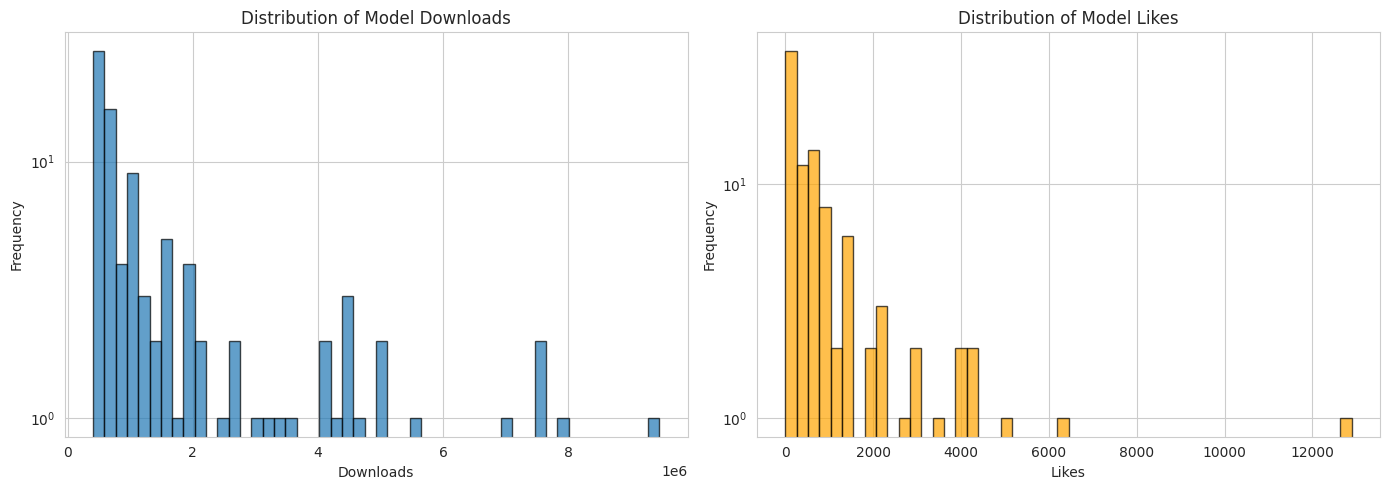


Downloads Statistics:
count    9.500000e+01
mean     1.806482e+06
std      1.958885e+06
min      4.029600e+05
25%      5.569825e+05
50%      9.474410e+05
75%      2.045906e+06
max      9.452248e+06
Name: downloads, dtype: float64

Likes Statistics:
count       95.000000
mean      1021.273684
std       1754.374365
min          0.000000
25%         88.000000
50%        474.000000
75%       1054.500000
max      12893.000000
Name: likes, dtype: float64


In [53]:
# CELL 5.2: Download & Likes Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Downloads distribution (log scale)
axes[0].hist(df_raw['downloads'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Downloads')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Model Downloads')
axes[0].set_yscale('log')

# Likes distribution
axes[1].hist(df_raw['likes'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Likes')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Model Likes')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Summary stats
print("\nDownloads Statistics:")
print(df_raw['downloads'].describe())
print("\nLikes Statistics:")
print(df_raw['likes'].describe())


### 5.3 Popular Model Architectures

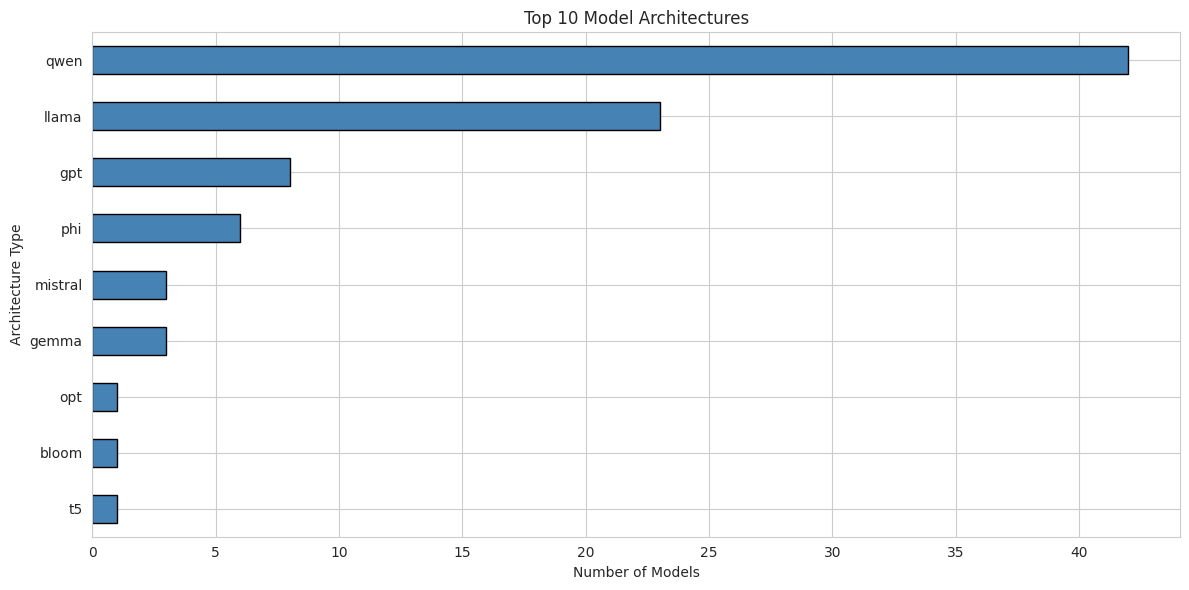


Total architectures identified: 9
Models without architecture tag: 7


In [54]:
# Popular Model Architectures
# Count models by architecture type
arch_counts = df_raw['model_type'].value_counts().head(10)

plt.figure(figsize=(12, 6))
arch_counts.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Number of Models')
plt.ylabel('Architecture Type')
plt.title('Top 10 Model Architectures')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTotal architectures identified: {df_raw['model_type'].nunique()}")
print(f"Models without architecture tag: {df_raw['model_type'].isna().sum()}")


### 5.4 License Distribution

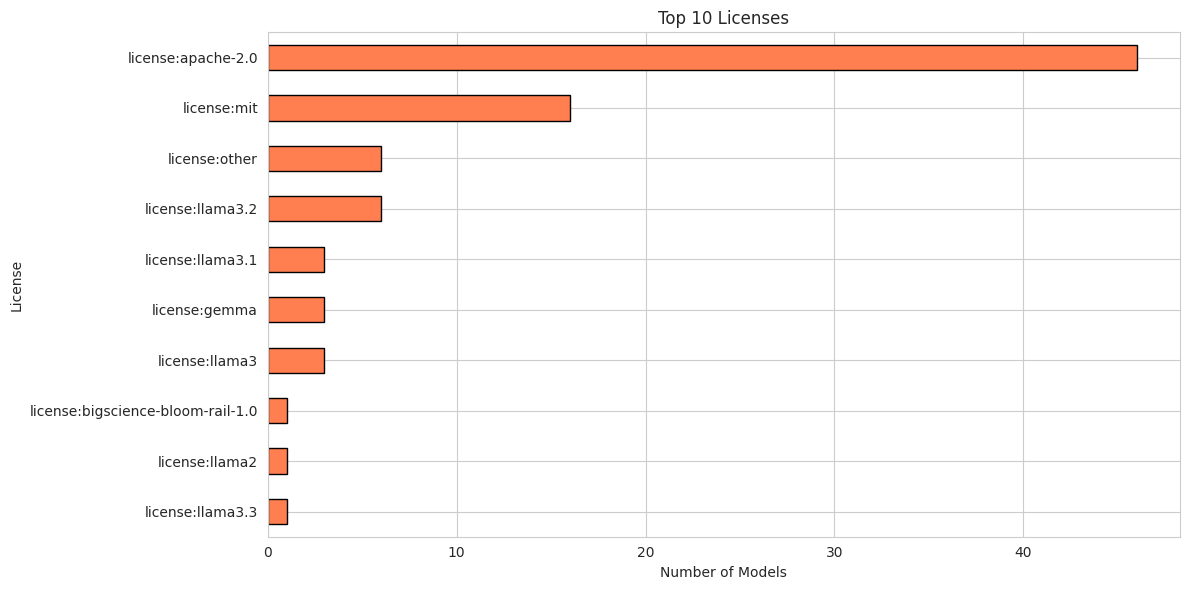


Total unique licenses: 10
Models without license: 9


In [55]:
# License Distribution
# Count models by license
license_counts = df_raw['license'].value_counts().head(10)

plt.figure(figsize=(12, 6))
license_counts.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Number of Models')
plt.ylabel('License')
plt.title('Top 10 Licenses')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTotal unique licenses: {df_raw['license'].nunique()}")
print(f"Models without license: {df_raw['license'].isna().sum()}")

### 5.5 Top Authors/Organizations

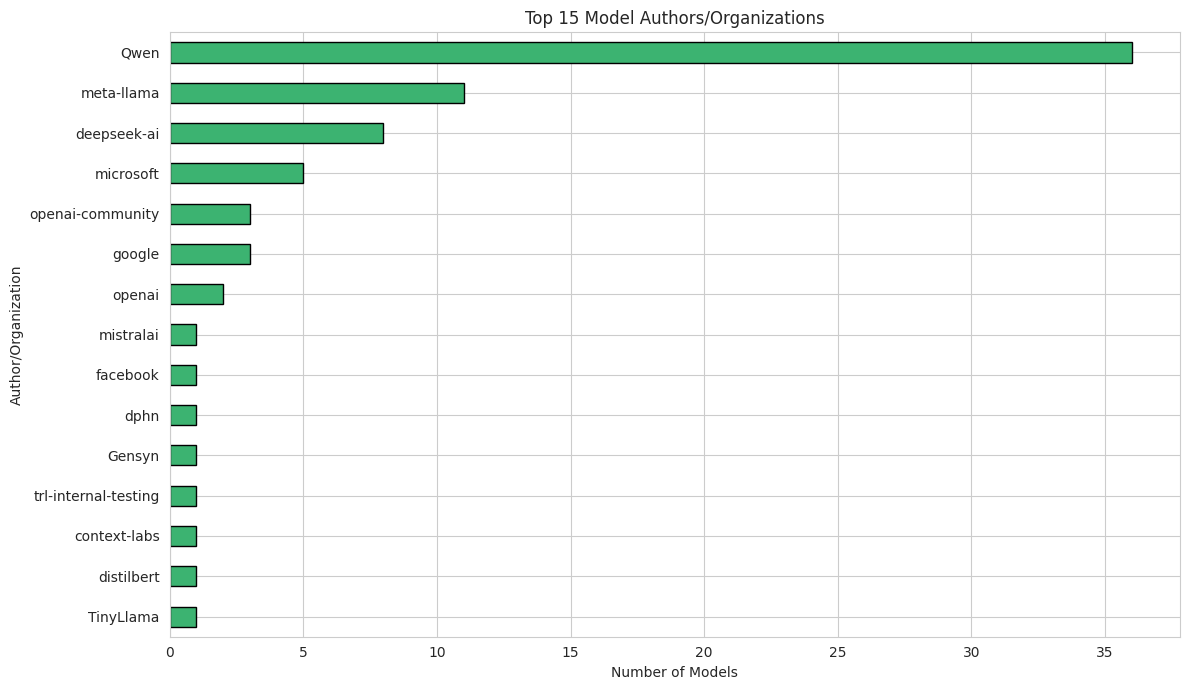


Top 5 Authors:
  Qwen: 36 models
  meta-llama: 11 models
  deepseek-ai: 8 models
  microsoft: 5 models
  openai-community: 3 models

Author Statistics:
  Total unique authors: 34
  Models with null author: 0 (0.0%)


In [56]:
# Top Authors/Organizations (FIXED)
# Check if author column has valid data
if df_raw['author'].notna().sum() == 0:
    print("⚠️  WARNING: No author information available in the dataset")
    print("   All author fields are null/empty")
    top_authors = pd.Series(dtype=int)
else:
    # Top model creators
    top_authors = df_raw['author'].value_counts().head(15)

    if len(top_authors) == 0:
        print("⚠️  WARNING: No authors found after filtering")
    else:
        plt.figure(figsize=(12, 7))
        top_authors.plot(kind='barh', color='mediumseagreen', edgecolor='black')
        plt.xlabel('Number of Models')
        plt.ylabel('Author/Organization')
        plt.title('Top 15 Model Authors/Organizations')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print(f"\nTop 5 Authors:")
        for author, count in top_authors.head(5).items():
            print(f"  {author}: {count} models")

# Summary statistics
total_authors = df_raw['author'].nunique()
null_authors = df_raw['author'].isna().sum()

print(f"\nAuthor Statistics:")
print(f"  Total unique authors: {total_authors}")
print(f"  Models with null author: {null_authors} ({null_authors/len(df_raw)*100:.1f}%)")



### 5.6 Missing Data Analysis

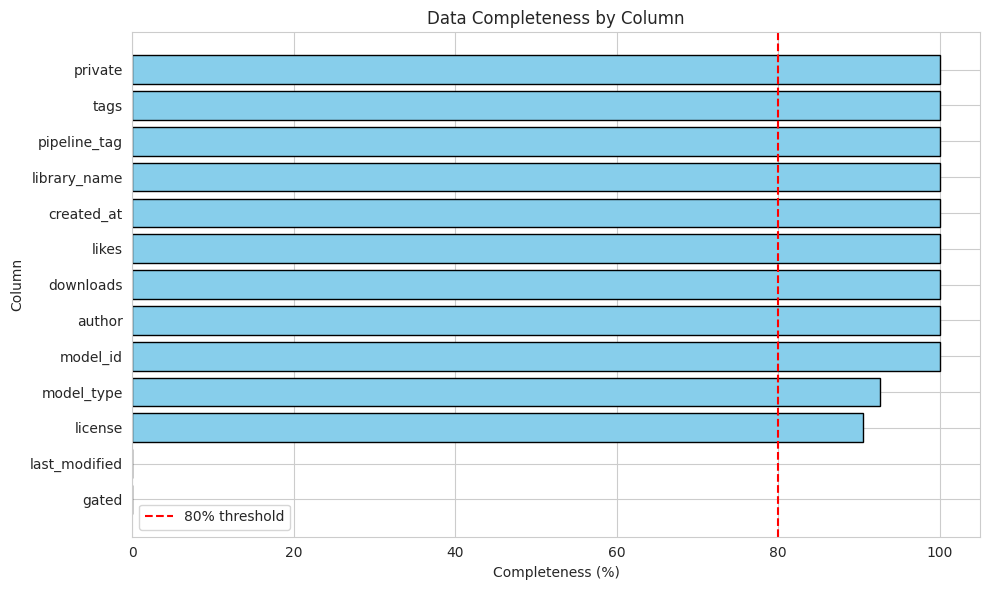


Data Completeness Report:
       column  completeness_pct
        gated          0.000000
last_modified          0.000000
      license         90.526316
   model_type         92.631579
     model_id        100.000000
       author        100.000000
    downloads        100.000000
        likes        100.000000
   created_at        100.000000
 library_name        100.000000
 pipeline_tag        100.000000
         tags        100.000000
      private        100.000000


In [57]:
 #Missing Data Analysis
# Calculate completeness for each column
completeness = (1 - df_raw.isnull().sum() / len(df_raw)) * 100
completeness_df = pd.DataFrame({
    'column': completeness.index,
    'completeness_pct': completeness.values
}).sort_values('completeness_pct')

plt.figure(figsize=(10, 6))
plt.barh(completeness_df['column'], completeness_df['completeness_pct'],
         color='skyblue', edgecolor='black')
plt.xlabel('Completeness (%)')
plt.ylabel('Column')
plt.title('Data Completeness by Column')
plt.axvline(x=80, color='red', linestyle='--', label='80% threshold')
plt.legend()
plt.tight_layout()
plt.show()

print("\nData Completeness Report:")
print(completeness_df.to_string(index=False))

### 5.7 Temporal Analysis


/tmp/ipython-input-617393149.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_raw['created_month'] = df_raw['created_at_dt'].dt.to_period('M')


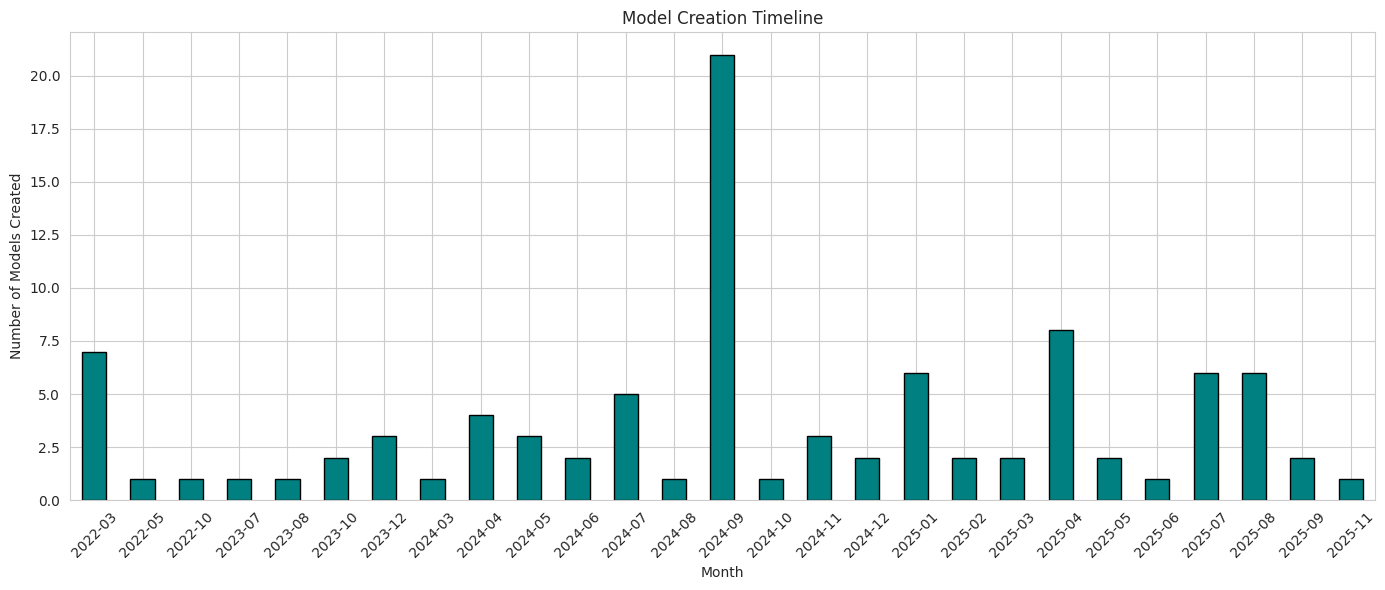

In [58]:
 # Temporal Analysis
# Convert timestamps to datetime
df_raw['created_at_dt'] = pd.to_datetime(df_raw['created_at'], errors='coerce')
df_raw['last_modified_dt'] = pd.to_datetime(df_raw['last_modified'], errors='coerce')

# Models created per month
df_raw['created_month'] = df_raw['created_at_dt'].dt.to_period('M')
monthly_counts = df_raw['created_month'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
monthly_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Models Created')
plt.title('Model Creation Timeline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Validation Checks

In [59]:
# Validation Checks
# Validate required columns
required_cols = [
    'model_id', 'author', 'downloads', 'likes',
    'tags', 'model_type', 'license'
]

validation_results = validate_dataframe(
    df_raw,
    required_cols,
    name="Raw Metadata"
)

# Additional checks
print(f"\n{'='*60}")
print("ADDITIONAL CHECKS")
print(f"{'='*60}")

# Check for duplicates
duplicates = df_raw['model_id'].duplicated().sum()
print(f"Duplicate model_ids: {duplicates}")

# Check for valid model IDs (should contain '/')
invalid_ids = df_raw[~df_raw['model_id'].str.contains('/', na=False)]
print(f"Invalid model_id format: {len(invalid_ids)}")

# Check numeric ranges
print(f"Negative downloads: {(df_raw['downloads'] < 0).sum()}")
print(f"Negative likes: {(df_raw['likes'] < 0).sum()}")




Validation Report: Raw Metadata
Shape: 95 rows × 16 columns
Valid: True

Null Counts:
  model_id: 0 (0.00%)
  author: 0 (0.00%)
  downloads: 0 (0.00%)
  likes: 0 (0.00%)
  tags: 0 (0.00%)
  model_type: 7 (7.37%)
  license: 9 (9.47%)

ADDITIONAL CHECKS
Duplicate model_ids: 0
Invalid model_id format: 0
Negative downloads: 0
Negative likes: 0


## 6Export Summary

In [60]:
# Create summary statistics
summary = {
    'metadata': {
        'fetch_date': pd.Timestamp.now().isoformat(),
        'total_models': len(df_raw),
        'execution_mode': 'light' if LIGHT_MODE else 'full'
    },
    'statistics': {
        'mean_downloads': float(df_raw['downloads'].mean()),
        'median_downloads': float(df_raw['downloads'].median()),
        'mean_likes': float(df_raw['likes'].mean()),
        'median_likes': float(df_raw['likes'].median()),
        'unique_authors': int(df_raw['author'].nunique()),
        'unique_architectures': int(df_raw['model_type'].nunique()),
        'unique_licenses': int(df_raw['license'].nunique())
    },
    'completeness': completeness.to_dict(),
    'validation': {
        'duplicates': int(duplicates),
        'invalid_ids': len(invalid_ids),
        'passed': validation_results['valid']
    }
}

# Save summary
summary_file = paths.PROCESSED_DIR / "metadata_summary.json"
save_json(summary, summary_file)

print(f"✅ Summary saved to: {summary_file}")
print(f"\n{'='*60}")
print("SPRINT 1 COMPLETE")
print(f"{'='*60}")
print(f"✅ Raw data: {raw_file}")
print(f"✅ Cache: {paths.CACHE_DIR / 'hf_metadata.db'}")
print(f"✅ Summary: {summary_file}")

✅ Summary saved to: /content/drive/MyDrive/llm-recommender-colab/data/processed/metadata_summary.json

SPRINT 1 COMPLETE
✅ Raw data: /content/drive/MyDrive/llm-recommender-colab/data/raw/hf_models_raw.parquet
✅ Cache: /content/drive/MyDrive/llm-recommender-colab/data/cache/hf_metadata.db
✅ Summary: /content/drive/MyDrive/llm-recommender-colab/data/processed/metadata_summary.json
